In [11]:
from datetime import date

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

Get hashrate data from NASDAQ API:

In [6]:
hr_response = requests.get('https://data.nasdaq.com/api/v3/datasets/BCHAIN/HRATE.json?api_key=CEZ47Us4M6dvsFYzReoG')
hr_data = hr_response.json()['dataset']['data']
hr_df = pd.DataFrame.from_records(hr_data, columns=['Date', 'Hashrate'])
hr_df['Day'] = list(reversed(range(0, len(hr_df.index))))
hr_df.sort_values(by='Day', ascending=True, inplace=True)
hr_df.reset_index(drop=True, inplace=True)
hr_df = hr_df[['Date', 'Day', 'Hashrate']]
hr_df['Date'] = pd.to_datetime(hr_df['Date'])
hr_df['Hashrate (Raw)'] = hr_df['Hashrate']*1000000000000
hr_df['Hashrate (Exa)'] = hr_df['Hashrate (Raw)'] / 1e18
hr_df

,Date,Day,Hashrate,Hashrate (Raw),Hashrate (Exa)
0,2009-01-03,0,0.000000e+00,0.000000e+00,0.000000
1,2009-01-04,1,0.000000e+00,0.000000e+00,0.000000
2,2009-01-05,2,0.000000e+00,0.000000e+00,0.000000
3,2009-01-06,3,0.000000e+00,0.000000e+00,0.000000
4,2009-01-07,4,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...
5057,2022-11-08,5057,2.978758e+08,2.978758e+20,297.875787
5058,2022-11-09,5058,2.722914e+08,2.722914e+20,272.291364
5059,2022-11-10,5059,2.686364e+08,2.686364e+20,268.636446
5060,2022-11-11,5060,2.448795e+08,2.448795e+20,244.879481


Plot hashrate over time:

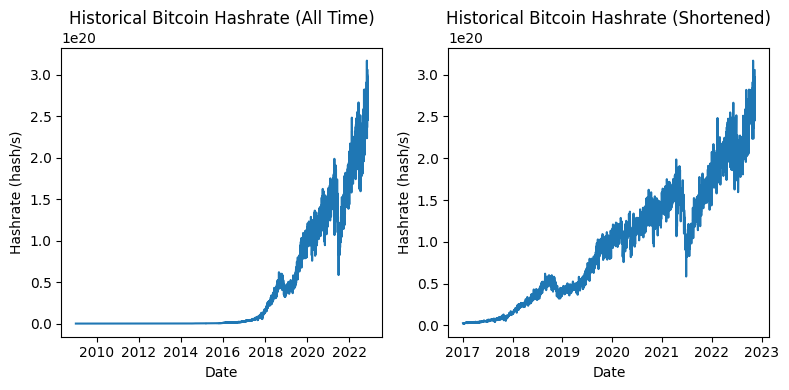

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(hr_df['Date'], hr_df['Hashrate (Raw)'])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Hashrate (hash/s)')
ax[0].set_title('Historical Bitcoin Hashrate (All Time)')

short_index =hr_df[hr_df['Date'] > pd.to_datetime(date(2017,1,1))].index
ax[1].plot(hr_df.loc[short_index, 'Date'], hr_df.loc[short_index, 'Hashrate (Raw)'])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Hashrate (hash/s)')
ax[1].set_title('Historical Bitcoin Hashrate (Shortened)')

plt.tight_layout()
plt.savefig('hr_historical.png')
plt.show()

Convert hashrate chart to expected years for birthday attack:

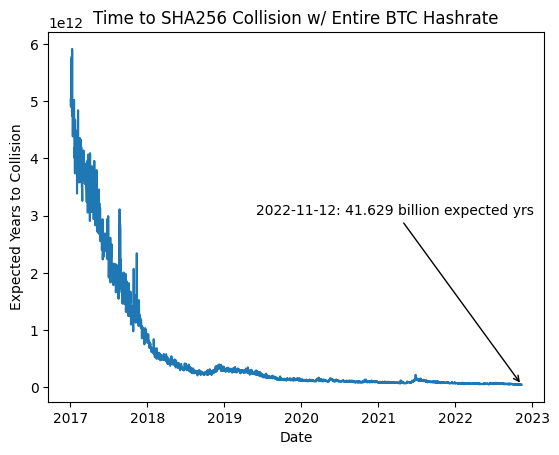

In [24]:
needed_hashes =1.17741*(2**128)
def hashrate_to_years(rate):
    seconds = needed_hashes / rate
    years = seconds / (60*60*24*365)
    return years

scaled_rates = hr_df.loc[short_index, 'Hashrate (Raw)']
years_actual = scaled_rates.apply(hashrate_to_years)

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df.loc[short_index, 'Date'], years_actual)
ax.annotate(
    f'{hr_df.iloc[-1]["Date"].date()}: {round(years_actual.iloc[-1] / 10**9, 3)} billion expected yrs',
    xy=(hr_df.iloc[-1]["Date"], years_actual.iloc[-1]),
    xycoords='data',
    xytext=(0.4, 0.5),
    textcoords='figure fraction',
    arrowprops=dict(arrowstyle='->', facecolor='r')
)
plt.title('Time to SHA256 Collision w/ Entire BTC Hashrate')
plt.xlabel('Date')
plt.ylabel('Expected Years to Collision')

plt.savefig('birthday.png')
plt.show()

Fit a logarithmic regression and plot:

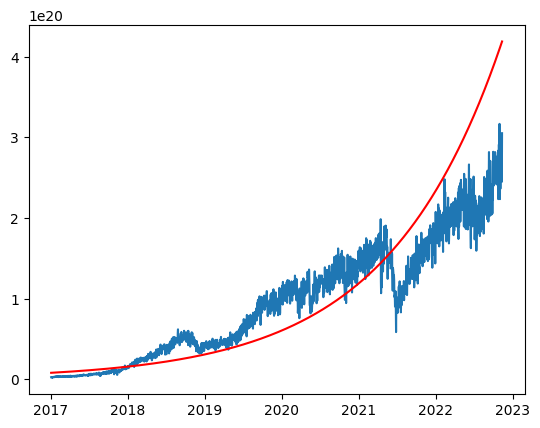

In [33]:
log_hashrate = np.log(hr_df.loc[short_index, 'Hashrate (Raw)'])
linear_reg = LinearRegression()
linear_reg.fit(hr_df.loc[short_index, 'Day'].values.reshape(-1,1), log_hashrate)
pred_hr = linear_reg.predict(hr_df.loc[short_index, 'Day'].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df.loc[short_index, 'Date'], hr_df.loc[short_index, 'Hashrate (Raw)'])
ax.plot(hr_df.loc[short_index, 'Date'], np.exp(pred_hr), 'r')
plt.show()

Refit discounting the large drop in hashrate:

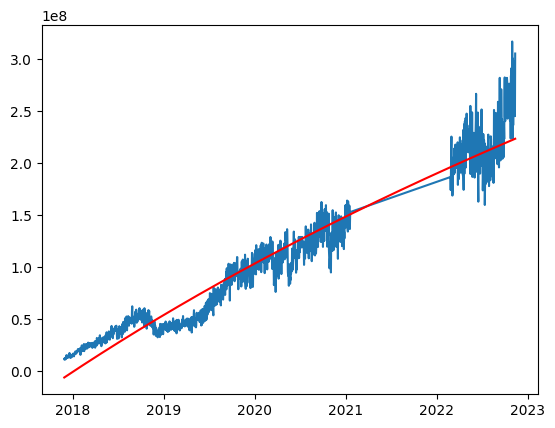

In [7]:
hr_df_cherry = hr_df_short.drop(list(range(4400, 4801)), axis=0)
linear_reg.fit(hr_df_cherry['ln_Day'].values.reshape(-1, 1), hr_df_cherry['Hashrate'])
pred_hr = linear_reg.predict(hr_df_short['ln_Day'].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df_cherry['Date'], hr_df_cherry['Hashrate'])
ax.plot(hr_df_short['Date'], pred_hr, 'r')
plt.show()

Project to day 1000:

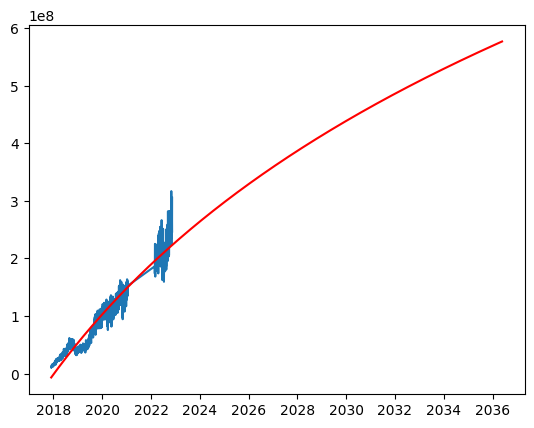

In [8]:
day_range = range(3250, 10001)
date_range = pd.to_datetime(range(1, len(day_range)+1), unit='D', origin=hr_df.loc[3250, 'Date'])

days_proj = np.array(day_range).reshape(-1,1)
days_proj_ln = np.log(days_proj)
pred_hr = linear_reg.predict(days_proj_ln)

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df_cherry['Date'], hr_df_cherry['Hashrate'])
ax.plot(date_range, pred_hr, 'r')
plt.show()

Time to generate a collision if we devote entire BTC hashrate to SHA 256 calculation (using actual data from our shortened timeframe):

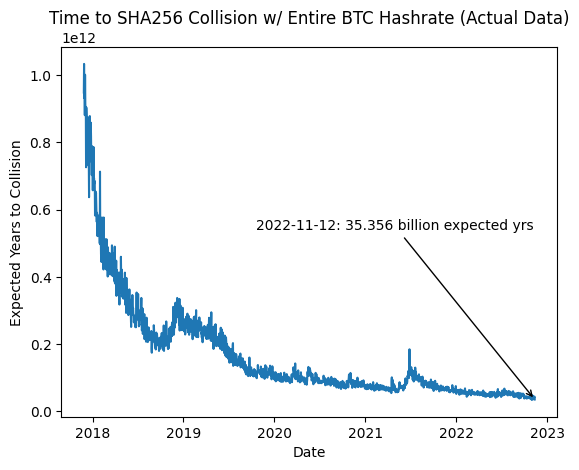

Now do the same for projected data starting from present:

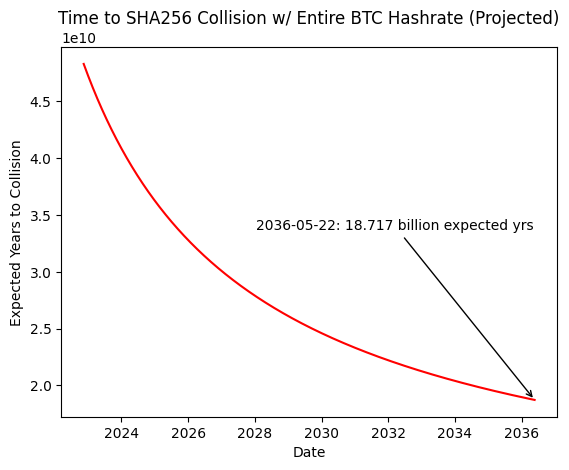

In [10]:
scaled_rates_proj = pred_hr[len(hr_df_short.index)+1:]*1000000000000
years_proj = pd.Series(scaled_rates_proj).apply(hashrate_to_years)

fig, ax = plt.subplots(1, 1)
ax.plot(date_range[len(hr_df_short.index)+1:], years_proj, 'r')
ax.annotate(
    f'{date_range[-1].date()}: {round(years_proj.iloc[-1] / 10**9, 3)} billion expected yrs',
    xy=(date_range[-1], years_proj.iloc[-1]),
    xycoords='data',
    xytext=(0.4, 0.5),
    textcoords='figure fraction',
    arrowprops=dict(arrowstyle='->')
)
plt.title('Time to SHA256 Collision w/ Entire BTC Hashrate (Projected)')
plt.xlabel('Date')
plt.ylabel('Expected Years to Collision')
plt.show()

In [11]:
linear_reg.coef_

array([5.18835337e+08])

In [12]:
pred_hr[730] - pred_hr[365]

49906752.19054222